# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [ ]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.1/378.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.2 MB/s eta 0:00:00


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [ ]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [2]:
import os
import getpass
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [3]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [4]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

dyld[98780]: Library not loaded: /usr/local/opt/libunistring/lib/libunistring.2.dylib
  Referenced from: <5BA9D142-2989-39F6-8E78-97F4C6F1F2C2> /usr/local/Cellar/wget/1.21.1/bin/wget
  Reason: tried: '/usr/local/opt/libunistring/lib/libunistring.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libunistring/lib/libunistring.2.dylib' (no such file), '/usr/local/opt/libunistring/lib/libunistring.2.dylib' (no such file), '/usr/local/lib/libunistring.2.dylib' (no such file), '/usr/lib/libunistring.2.dylib' (no such file, not in dyld cache), '/usr/local/Cellar/libunistring/1.2/lib/libunistring.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/Cellar/libunistring/1.2/lib/libunistring.2.dylib' (no such file), '/usr/local/Cellar/libunistring/1.2/lib/libunistring.2.dylib' (no such file), '/usr/local/lib/libunistring.2.dylib' (no such file), '/usr/lib/libunistring.2.dylib' (no such file, not in dyld cache)
dyld[98783]: Library not loaded: /usr/lo

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [6]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [7]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 2, 27, 11, 31, 19, 224725)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [8]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [9]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [11]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [12]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [13]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick. The reviews praised its action sequences, Keanu Reeves' performance, and the overall entertainment value of the film."

In [14]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- Review Title: "A Masterpiece & Brilliant Sequel"\n- URL: \'/review/rw4854296/?ref_=tt_urv\''

In [15]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is about an ex-hitman who comes out of retirement seeking vengeance on the gangsters that killed his dog and took everything from him. He gets dragged into a situation where he must unleash a maelstrom of destruction against those who are after him, leading to intense action and fights.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [16]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [17]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [18]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Opinions on John Wick seem to vary. Some people really enjoyed the movie, praising its action sequences, style, and Keanu Reeves' performance. However, others found it lacking in plot and substance. It ultimately depends on personal preference whether people liked John Wick or not."

In [19]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'I do not have any reviews with a rating of 10 in the provided context.'

In [ ]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is a movie known for its beautifully choreographed action scenes and emotional setup. It stars Keanu Reeves and is highly recommended for action movie fans.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [20]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [21]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [22]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems like people generally really liked John Wick. The reviews praise the film for its slickness, brilliance in action sequences, Keanu Reeves' performance, and overall entertainment value."

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n- Review URL: /review/rw4854296/?ref_=tt_urv'

In [27]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, after resolving his issues with the Russian mafia, John Wick is forced back into action when mobster Santino D'Antonio asks him to kill his sister in Rome. When Wick completes the task, Santino puts a bounty on him, leading to professional killers coming after him. Wick then seeks revenge on Santino."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [22]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [23]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [25]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. The reviews praise the action sequences, the performance of Keanu Reeves, and the overall entertainment value of the movie.'

In [27]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, there are no reviews with a rating of 10 in the provided context."

In [28]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the story follows a retired assassin named John Wick who comes out of retirement after someone kills his dog and steals his car, leading to a lot of carnage. He is then called on to pay off an old debt by helping take over the Assassin's Guild by traveling to Italy, Canada, and Manhattan to eliminate numerous assassins."

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [26]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [27]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/var/folders/ng/cm39njz1295g1l691m97bc1c0000gn/T/ipykernel_97884/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [28]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [29]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [30]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [31]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Overall, opinions on John Wick seem to vary. Some people really enjoy the series and find it consistent and well-received, while others may not like certain aspects of the movies, such as the plot or action scenes. It really depends on individual preferences.'

In [35]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [36]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, John Wick is a retired assassin who comes out of retirement to seek revenge after someone kills his dog and steals his car. He is then called on to pay off an old debt by helping Ian McShane take over the Assassin's Guild by flying around to Italy, Canada, and Manhattan and killing numerous assassins."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [32]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [33]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [34]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"People generally liked John Wick based on the reviews provided. The action sequences, Keanu Reeves' performance, and the overall style of the movie were praised by reviewers."

In [40]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is one review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [41]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is an action-packed movie series that follows the story of a retired hitman, John Wick, who seeks vengeance after gangsters kill his dog and steal his car. This leads to a series of violent confrontations with various enemies throughout the movies.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [ ]:
#!pip install -qU langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [35]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [36]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [37]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [38]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [39]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [40]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive reviews provided in the context.'

In [ ]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is one review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [ ]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is an ultra-violent movie series that follows the story of an ex-hitman seeking revenge after gangsters killed his dog and took everything from him. The first installment features John Wick coming out of retirement to track down those responsible. The series is known for its elaborate action sequences, vivid choreography, and intense violence.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [49]:

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator


generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node d2bb09d2-3ef6-4eeb-94c3-da5a1d92faee does not have a summary. Skipping filtering.
Node a566e5c5-0321-41cd-adb6-88bc53efdbc0 does not have a summary. Skipping filtering.
Node eaddbfe4-4622-4ec7-9395-47d94ab859d3 does not have a summary. Skipping filtering.
Node b58d72a7-c44c-48f2-b337-554e10e2ca34 does not have a summary. Skipping filtering.
Node 9a140302-a88e-4c01-918e-90376c896cb6 does not have a summary. Skipping filtering.
Node d2d1d11e-f493-4f90-a1a6-79e83fb4989c does not have a summary. Skipping filtering.
Node 2e2064ab-39c0-40ac-82f1-ce0710087a30 does not have a summary. Skipping filtering.
Node 54832d65-80aa-4519-bcf5-d5ffdfff0d46 does not have a summary. Skipping filtering.
Node 9ef4464f-6d97-4b5c-a381-25d45f112c63 does not have a summary. Skipping filtering.
Node bfbba0b4-fd57-4185-8bd2-3d59b7127789 does not have a summary. Skipping filtering.
Node 54204f4f-da49-4aa9-a9ed-b63c84c219d8 does not have a summary. Skipping filtering.
Node db738284-2f18-408e-88a0-fcff33315132 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [70]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Why Keanu Reeves in John Wick?,[: 11\nReview: Who needs a 2hr and 40 min acti...,[: 0\nReview: The best way I can describe John...,I don't know.,"Keanu Reeves plays John Wick, a relatable hero...",single_hop_specifc_query_synthesizer
1,What is the general reception of the John Wick...,[: 8\nReview: It's hard to find anything bad t...,[: 2\nReview: With the fourth installment scor...,The general reception of the John Wick series ...,The John Wick series is apparently loved by ev...,single_hop_specifc_query_synthesizer
2,What is the main plot of the movie John wick w...,[: 4\nReview: Hollow plot interspersed with th...,[: 3\nReview: John wick has a very simple reve...,The main plot of the movie John Wick is about ...,John Wick has a very simple revenge story that...,single_hop_specifc_query_synthesizer
3,How does Keanu Reeves' portrayal of John Wick ...,"[: 9\nReview: At first glance, John Wick sound...",[: 4\nReview: Though he no longer has a taste ...,Keanu Reeves' portrayal of John Wick in the fi...,Keanu Reeves' portrayal of John Wick is marked...,single_hop_specifc_query_synthesizer
4,How does the character of the Russian mob prin...,[: 5\nReview: Ultra-violent first entry with l...,[: 5\nReview: Ultra-violent first entry with l...,The character of the Russian mob prince in Joh...,The Russian mob prince plays a crucial role in...,single_hop_specifc_query_synthesizer
5,What genre did the filmmakers forget to add to...,[: 19\nReview: John Wick: Chapter 4 picks up w...,"[<1-hop>\n\n: 21\nReview: ..THE FILM-MAKERS, {...","The filmmakers forgot to add the ""martial arts...",The filmmakers forgot to add 'FANTASY' to thei...,multi_hop_specific_query_synthesizer
6,How does the involvement of Russian mobsters i...,"[: 9\nReview: At first glance, John Wick sound...",[<1-hop>\n\n: 18\nReview: When the story begin...,The involvement of Russian mobsters in John Wi...,The involvement of Russian mobsters in John Wi...,multi_hop_specific_query_synthesizer
7,What makes John Wick 3 stand out as an action ...,[: 22\nReview: Lets contemplate about componen...,[<1-hop>\n\n: 16\nReview: John Wick 3 is witho...,John Wick 3 stands out as an action movie comp...,John Wick 3 stands out as an action movie due ...,multi_hop_specific_query_synthesizer
8,Why is it considered a shame that Hollywood st...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\n: 10\nReview: Most American action...,It is considered a shame that Hollywood strugg...,It is considered a shame that Hollywood strugg...,multi_hop_specific_query_synthesizer
9,What are the similarities and differences in t...,[: 16\nReview: John Wick Chapter 2 pits Keanu ...,[<1-hop>\n\n: 20\nReview: John Wick is somethi...,In the portrayal of Reeves' character in John ...,"In John Wick, Reeves' character is portrayed a...",multi_hop_specific_query_synthesizer


In [72]:
# save the dataset
dataset.to_csv("john_wick_testset.csv")

In [ ]:
import os
from langsmith import Client

# Set up LangSmith environment
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangChain API Key:")
os.environ["LANGCHAIN_PROJECT"] = "retriever_comparison"

In [ ]:
import logging
from ragas import evaluate as ragas_evaluate
from ragas.llms import LangchainLLMWrapper
from ragas import EvaluationDataset
from ragas.metrics import (
    LLMContextRecall,
    FactualCorrectness,
    ResponseRelevancy,
    ContextEntityRecall,
    NoiseSensitivity
)
from ragas import RunConfig
from langchain_openai import ChatOpenAI
from langsmith import traceable

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

custom_run_config = RunConfig(timeout=360)
langsmith_client = Client()

@traceable(client=langsmith_client, tags=["evaluation"])
def chain_evaluation(dataset, chain, retriever):
    '''Evaluate a chain on a test dataset given a retriever'''

    for test_row in dataset:
        response = chain.invoke({"question": test_row.eval_sample.user_input}, {"tags": [retriever]})
        test_row.eval_sample.response = response["response"].content
        test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

    evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
    evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

    return ragas_evaluate(
        dataset=evaluation_dataset,
        metrics=[
            LLMContextRecall(),
            FactualCorrectness(),
            ResponseRelevancy(),
            ContextEntityRecall(),
            NoiseSensitivity()
        ],
        llm=evaluator_llm,
        run_config=custom_run_config
    )

retriever_list = [
    bm25_retrieval_chain,
    naive_retrieval_chain,
    parent_document_retrieval_chain,
    contextual_compression_retrieval_chain,
    multi_query_retrieval_chain,
    ensemble_retrieval_chain,
    semantic_retrieval_chain,
]
retriever_str_names = [
    "BM25",
    "Naive",
    "Parent Document",
    "Contextual Compression",
    "Multi Query",
    "Ensemble",
    "Semantic",
]

results = {}
for retriever, name in zip(retriever_list, retriever_str_names):
    logger.info(f"Evaluating {name}")
    result = chain_evaluation(dataset, retriever, name)
    results[name] = result
    logger.info(f"Results for {name}: {result}")



### LANGSMITH specific evals

In [78]:
from langsmith.evaluation import EvaluationResult, RunEvaluator, evaluate as langsmith_evaluate
from typing import Optional, Dict, Any
from langchain_core.messages import HumanMessage

class RetrievalRelevanceEvaluator(RunEvaluator):
    def __init__(self):
        self.llm = ChatOpenAI(model="gpt-4", temperature=0)
        
        self.eval_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are an expert evaluator assessing the quality and relevance of retrieved context and answers for a question-answering system. 
            
            You will evaluate the retrieved context and answer based on the following criteria:
            1. Context Relevance (0-5): How relevant and useful is the retrieved context for answering the question?
            2. Answer Accuracy (0-5): How accurate and complete is the answer based on the provided context?
            3. Context Utilization (0-5): How well does the answer utilize the relevant information from the context?

            Provide your evaluation in the following format:
            {
                "context_relevance": <score>,
                "answer_accuracy": <score>,
                "context_utilization": <score>,
                "overall_score": <average of all scores>,
                "reasoning": "<detailed explanation of scores>"
            }"""),
            ("human", """Question: {question}

Retrieved Context:
{context}

Generated Answer:
{answer}

Evaluate the retrieval and answer quality.""")
        ])

    def evaluate_run(
        self, run: Any, example: Optional[Dict] = None
    ) -> EvaluationResult:
        """Evaluate a run."""
        try:
            # Extract relevant information
            question = run.inputs["question"]
            answer = run.outputs["response"].content
            context_docs = run.outputs["context"]
            
            # Format context for evaluation
            formatted_context = "\n".join([doc.page_content for doc in context_docs])
            
            # Get evaluation from GPT-4
            evaluation = self.llm.invoke(
                [
                    HumanMessage(content=self.eval_prompt.format_messages()[0].content),
                    HumanMessage(content=self.eval_prompt.format_messages()[1].content.format(
                        question=question,
                        context=formatted_context,
                        answer=answer
                    ))
                ]
            )
            
            # Parse the evaluation results
            results = eval(evaluation.content)
            
            return EvaluationResult(
                key="retrieval_relevance",
                score=results["overall_score"],
                feedback=results["reasoning"],
                metadata={
                    "context_relevance": results["context_relevance"],
                    "answer_accuracy": results["answer_accuracy"],
                    "context_utilization": results["context_utilization"]
                }
            )
        except Exception as e:
            return EvaluationResult(
                key="retrieval_relevance",
                score=0.0,
                feedback=f"Evaluation failed: {str(e)}",
            )

def evaluate_with_langsmith(chain_name, dataset, chain, retrieval_relevance):
    DATASET_NAME = f"John Wick Movie Review RAG - {chain_name}"

    if langsmith_client.has_dataset(dataset_name=DATASET_NAME):
        langsmith_dataset = langsmith_client.read_dataset(dataset_name=DATASET_NAME)
    else:
        langsmith_dataset = langsmith_client.create_dataset(
            dataset_name=DATASET_NAME,
            description=f"John Wick movie review RAG with {chain_name}"
        )

    for test_row in dataset:
        user_input = test_row.user_input
        print(f"Generating response for: {user_input}")
        response = chain.invoke({"question": user_input})
        langsmith_client.create_example(
            inputs={
                "question": user_input
            },
            outputs={
                "response": response["response"],
                "context": response["context"],
            },
            metadata={
                "name": chain_name,
            },
            dataset_id=langsmith_dataset.id,
        )

    langsmith_evaluate(
        chain.invoke,
        data=DATASET_NAME,
        evaluators=[
            retrieval_relevance
        ],
        experiment_prefix="john-wick-rag",
        client=langsmith_client
    )

retrieval_relevance = RetrievalRelevanceEvaluator()
eval_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())
for retriever, name in zip(retriever_list, retriever_str_names):
    logger.info(f"Evaluating {name}")
    evaluate_with_langsmith(name, eval_dataset, retriever, retrieval_relevance)

INFO:__main__:Evaluating BM25


Generating response for: Why Keanu Reeves in John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the general reception of the John Wick series?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the main plot of the movie John wick with Keanu?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does Keanu Reeves' portrayal of John Wick contribute to the film's overall impact and 
character development?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the character of the Russian mob prince contribute to the overall narrative of 
John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What genre did the filmmakers forget to add to their list for JOHN WICK, CHAPTER 3 : 
PARABELLUM, and how does the film's style compare to other action films?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the involvement of Russian mobsters in John Wick's life contribute to the overall
narrative and character development in the film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What makes John Wick 3 stand out as an action movie compared to the original John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: Why is it considered a shame that Hollywood struggles with originality in action films, 
especially in the context of the John Wick franchise and the mess of the latest Keanu Reeves film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What are the similarities and differences in the portrayal of Reeves' character in John 
Wick compared to typical action movie tropes?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


View the evaluation results for experiment: 'john-wick-rag-dd37c5d7' at:
https://smith.langchain.com/o/7acbdd88-ea69-5821-8eee-b1b6853db36b/datasets/18b367c1-c7ab-4dd5-aa21-9d2bc7b4bf59/compare?selectedSessions=eadba511-56d0-4307-9702-23da1e87a24d




0it [00:00, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

Generating response for: Why Keanu Reeves in John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the general reception of the John Wick series?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the main plot of the movie John wick with Keanu?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does Keanu Reeves' portrayal of John Wick contribute to the film's overall impact and 
character development?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the character of the Russian mob prince contribute to the overall narrative of 
John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What genre did the filmmakers forget to add to their list for JOHN WICK, CHAPTER 3 : 
PARABELLUM, and how does the film's style compare to other action films?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the involvement of Russian mobsters in John Wick's life contribute to the overall
narrative and character development in the film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What makes John Wick 3 stand out as an action movie compared to the original John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: Why is it considered a shame that Hollywood struggles with originality in action films, 
especially in the context of the John Wick franchise and the mess of the latest Keanu Reeves film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What are the similarities and differences in the portrayal of Reeves' character in John 
Wick compared to typical action movie tropes?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


View the evaluation results for experiment: 'john-wick-rag-b5f82ae1' at:
https://smith.langchain.com/o/7acbdd88-ea69-5821-8eee-b1b6853db36b/datasets/13875c70-8eee-4080-9b93-361217376404/compare?selectedSessions=c62dc274-51f8-45b4-ad91-f32ac548f2a8




0it [00:00, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Generating response for: Why Keanu Reeves in John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the general reception of the John Wick series?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the main plot of the movie John wick with Keanu?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does Keanu Reeves' portrayal of John Wick contribute to the film's overall impact and 
character development?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the character of the Russian mob prince contribute to the overall narrative of 
John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What genre did the filmmakers forget to add to their list for JOHN WICK, CHAPTER 3 : 
PARABELLUM, and how does the film's style compare to other action films?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the involvement of Russian mobsters in John Wick's life contribute to the overall
narrative and character development in the film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What makes John Wick 3 stand out as an action movie compared to the original John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: Why is it considered a shame that Hollywood struggles with originality in action films, 
especially in the context of the John Wick franchise and the mess of the latest Keanu Reeves film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What are the similarities and differences in the portrayal of Reeves' character in John 
Wick compared to typical action movie tropes?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


View the evaluation results for experiment: 'john-wick-rag-276f1362' at:
https://smith.langchain.com/o/7acbdd88-ea69-5821-8eee-b1b6853db36b/datasets/00ccf17b-fdab-4962-8fc2-0f803a2b2d7b/compare?selectedSessions=98fff3c8-7d38-42b8-bd4a-ece39c5a0093




0it [00:00, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Generating response for: Why Keanu Reeves in John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the general reception of the John Wick series?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the main plot of the movie John wick with Keanu?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does Keanu Reeves' portrayal of John Wick contribute to the film's overall impact and 
character development?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the character of the Russian mob prince contribute to the overall narrative of 
John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What genre did the filmmakers forget to add to their list for JOHN WICK, CHAPTER 3 : 
PARABELLUM, and how does the film's style compare to other action films?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the involvement of Russian mobsters in John Wick's life contribute to the overall
narrative and character development in the film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What makes John Wick 3 stand out as an action movie compared to the original John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: Why is it considered a shame that Hollywood struggles with originality in action films, 
especially in the context of the John Wick franchise and the mess of the latest Keanu Reeves film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What are the similarities and differences in the portrayal of Reeves' character in John 
Wick compared to typical action movie tropes?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


View the evaluation results for experiment: 'john-wick-rag-08919b28' at:
https://smith.langchain.com/o/7acbdd88-ea69-5821-8eee-b1b6853db36b/datasets/ff575670-c757-489b-809f-b1986f45f8b3/compare?selectedSessions=06291480-746d-4d23-b9d7-67a93109d86f




0it [00:00, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 429 Too Many Requests"
ERROR:langsmith.evaluation._runner:Error running target function: status_code: 429, body: {'message': "You are using a Trial key, which is limited to 10 API calls / minute. You can continue to use the Trial key for free or upgrade to a Production key with higher rate limits at 'https://dashboard.cohere.com/api-keys'. Contact us on 'https://discord.gg/XW44jPfYJu' or email us at support@cohere.com with any questions"}
Traceback (most recent call last):
  File "/Users/vprzybylo/Desktop/NG/AIE5/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/langsmith/evaluation/_runner.py", line 1914, in _forward
    fn(
    ~~^
        *args,
        ^^^^^^
        langsmith_extra=langsmith_extra,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/vprzybylo/Desktop/NG/AIE5/13_Advanced_Retrieval/.venv/

Generating response for: Why Keanu Reeves in John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['What makes Keanu Reeves the ideal choice for John Wick?', 'What attributes of Keanu Reeves suit the character in John Wick?', 'How does Keanu Reeves embody the role of John Wick?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the general reception of the John Wick series?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['1. How have audiences and critics generally received the John Wick series?', '2. What is the overall consensus on the reception of the John Wick franchise?', '3. How has the public responded to the John Wick movies in general?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the main plot of the movie John wick with Keanu?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['1. Can you provide a brief summary of the storyline in the movie John Wick starring Keanu Reeves?', '2. What is the central narrative focus of the film John Wick featuring Keanu Reeves in the lead role?', '3. What is the primary storyline in the movie John Wick, where Keanu Reeves plays a significant role?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does Keanu Reeves' portrayal of John Wick contribute to the film's overall impact and 
character development?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["What impact does Keanu Reeves' portrayal of John Wick have on the film's character development and overall effectiveness?", "How does Keanu Reeves' interpretation of John Wick influence the film's character evolution and overall impression?", "In what ways does Keanu Reeves' depiction of John Wick shape the film's overall impact and character growth?"]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the character of the Russian mob prince contribute to the overall narrative of 
John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['What impact does the personality of the Russian mob prince have on the storyline of John Wick?', 'In what ways does the portrayal of the Russian mob prince shape the overall narrative of John Wick?', 'How does the character of the Russian mob prince influence the development of the storyline in John Wick?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What genre did the filmmakers forget to add to their list for JOHN WICK, CHAPTER 3 : 
PARABELLUM, and how does the film's style compare to other action films?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["What genre was overlooked in the list for JOHN WICK, CHAPTER 3 : PARABELLUM by the filmmakers, and in what ways does the film's style differ from other action films?", "In JOHN WICK, CHAPTER 3 : PARABELLUM, which genre was omitted from the filmmakers' list, and how does the film's style contrast with other action movies?", "What specific genre was not included in the filmmakers' list for JOHN WICK, CHAPTER 3 : PARABELLUM, and what sets the film's style apart from other action films?"]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the involvement of Russian mobsters in John Wick's life contribute to the overall
narrative and character development in the film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['What impact do Russian mobsters have on the storyline and character growth of John Wick in the movie?', 'In what ways do Russian mobsters influence the overarching narrative and character evolution of John Wick in the film?', 'How does the presence of Russian mobsters shape the overall plot and character development of John Wick in the movie?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What makes John Wick 3 stand out as an action movie compared to the original John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['1. How does the action in John Wick 3 differ from the original John Wick movie?', '2. In what ways does John Wick 3 set itself apart as an action film when compared to the first John Wick movie?', '3. What unique aspects of John Wick 3 elevate it as an action movie in contrast to the original John Wick film?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: Why is it considered a shame that Hollywood struggles with originality in action films, 
especially in the context of the John Wick franchise and the mess of the latest Keanu Reeves film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['What are some reasons behind the criticism of Hollywood for lacking originality in action films, particularly when comparing it to the John Wick franchise and recent Keanu Reeves movies?', "In what ways does Hollywood's challenge with creating original action films, as seen in the John Wick franchise and Keanu Reeves' latest film, impact the overall perception of the industry?", "How does the issue of originality in action films, exemplified by Hollywood's struggles and the recent Keanu Reeves movie, reflect a larger trend in the entertainment industry?"]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST htt

Generating response for: What are the similarities and differences in the portrayal of Reeves' character in John 
Wick compared to typical action movie tropes?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["How does Reeves' character in John Wick differ from the typical action movie protagonist?", "In what ways is Reeves' portrayal in John Wick similar to and distinct from common action movie tropes?", "Can you highlight the similarities and variances in how Reeves' character is depicted in John Wick versus traditional action movie stereotypes?"]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


View the evaluation results for experiment: 'john-wick-rag-50ae6781' at:
https://smith.langchain.com/o/7acbdd88-ea69-5821-8eee-b1b6853db36b/datasets/fd95125a-1fde-4ca2-b307-2853f043b035/compare?selectedSessions=ffb7ca93-9c01-42dd-ab97-5571e19899bf




0it [00:00, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["How does Reeves' character in John Wick compare to traditional action movie stereotypes in terms of portrayal?", "What commonalities and distinctions can be found in the depiction of Reeves' character in John Wick versus standard action movie clichés?", "In what ways does the portrayal of Reeves' character in John Wick differ from the typical tropes seen in action movies?"]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_quer

Generating response for: Why Keanu Reeves in John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['1. What is the reason for choosing Keanu Reeves for the role of John Wick?', '2. How did Keanu Reeves become involved in the John Wick franchise?', '3. What factors led to the casting of Keanu Reeves as John Wick?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.o

Generating response for: What is the general reception of the John Wick series?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['1. How have audiences and critics generally received the John Wick series?', '2. What is the overall consensus on the reception of the John Wick franchise?', '3. How are the John Wick movies typically perceived by viewers and reviewers?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Requ

Generating response for: What is the main plot of the movie John wick with Keanu?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['1. Can you provide a summary of the primary storyline in the movie John Wick starring Keanu Reeves?', '2. What are the central events and narrative focus in the film John Wick featuring Keanu Reeves?', '3. Could you explain the key plot points and developments in the movie John Wick with Keanu Reeves?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://a

Generating response for: How does Keanu Reeves' portrayal of John Wick contribute to the film's overall impact and 
character development?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["What impact does Keanu Reeves' portrayal of John Wick have on the overall tone and character development of the film?", "In what ways does Keanu Reeves' performance as John Wick influence the film's overall impact and character progression?", "How does Keanu Reeves' depiction of John Wick shape the overall impact and development of the film's characters?"]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HT

Generating response for: How does the character of the Russian mob prince contribute to the overall narrative of 
John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["What impact does the Russian mob prince's character have on the storyline of John Wick?", 'In what ways does the Russian mob prince shape the overarching narrative of John Wick?', 'How does the presence of the Russian mob prince influence the overall plot development in John Wick?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embe

Generating response for: What genre did the filmmakers forget to add to their list for JOHN WICK, CHAPTER 3 : 
PARABELLUM, and how does the film's style compare to other action films?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["What genre was possibly overlooked in the list of genres for JOHN WICK, CHAPTER 3 : PARABELLUM, and in what ways does the film's style differ from other action films?", "What other genre could have been included in the genre list for JOHN WICK, CHAPTER 3 : PARABELLUM, and how does the film's stylistic approach set it apart from other action films?", "Is there a genre that the filmmakers missed when categorizing JOHN WICK, CHAPTER 3 : PARABELLUM, and how does the film's unique style differentiate it from other

Generating response for: How does the involvement of Russian mobsters in John Wick's life contribute to the overall
narrative and character development in the film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["1. In what ways do the actions of Russian mobsters impact John Wick's story arc and character evolution throughout the movie?", "2. How does the presence of Russian criminals influence John Wick's journey and personality growth within the film's narrative?", '3. What role do Russian mobsters play in shaping the storyline and character dynamics of John Wick in the movie?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v

Generating response for: What makes John Wick 3 stand out as an action movie compared to the original John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['1. How does the action in John Wick 3 differentiate it from the first John Wick movie?', '2. In what ways does John Wick 3 distinguish itself as an action film when compared to the original John Wick?', '3. What are the key elements that set John Wick 3 apart from the original John Wick in terms of action sequences and storytelling?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:ht

Generating response for: Why is it considered a shame that Hollywood struggles with originality in action films, 
especially in the context of the John Wick franchise and the mess of the latest Keanu Reeves film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["What are the reasons behind Hollywood's difficulty with coming up with original ideas for action films, specifically when looking at the John Wick franchise and the recent Keanu Reeves movie?", 'Why does Hollywood face criticism for its lack of originality in action movies, particularly when comparing it to the John Wick series and the recent film starring Keanu Reeves?', "In what ways does Hollywood's struggle to innovate in action films, like the John Wick franchise and the latest Keanu Reeves film, impact 

Generating response for: What are the similarities and differences in the portrayal of Reeves' character in John 
Wick compared to typical action movie tropes?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["How does the portrayal of Reeves' character in John Wick compare to common tropes seen in action movies?", "How does John Wick depict Reeves' character differently from traditional action movie stereotypes?", "What unique qualities does Reeves' character in John Wick possess that set him apart from typical action movie archetypes?"]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:http

View the evaluation results for experiment: 'john-wick-rag-e5925b34' at:
https://smith.langchain.com/o/7acbdd88-ea69-5821-8eee-b1b6853db36b/datasets/903c932e-138d-4cb4-910d-7091aa51c884/compare?selectedSessions=640c1f8e-ac21-48e0-b62f-0d387c0d7b83




0it [00:00, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 429 Too Many Requests"
ERROR:langsmith.evaluation._runner:Error running target function: status_code: 429, body: {'message': "You are using a Trial key, which is limited to 10 API calls / minute. You can continue to use the Trial key for free or upgrade to a Production key with higher rate limits at 'https://dashboard.cohere.com/api-keys'. Contact us on 'https://discord.gg/XW44jPfYJu' or email us at support@cohere.com with any questions"}
Traceback (most recent call last):
  File "/Users/vprzybylo/Desktop/NG/AIE5/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/langsmith/evaluation/_runner.py", line 1914, in _forward
    fn(
    ~~^
        *args,
        

Generating response for: Why Keanu Reeves in John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the general reception of the John Wick series?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What is the main plot of the movie John wick with Keanu?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does Keanu Reeves' portrayal of John Wick contribute to the film's overall impact and 
character development?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the character of the Russian mob prince contribute to the overall narrative of 
John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What genre did the filmmakers forget to add to their list for JOHN WICK, CHAPTER 3 : 
PARABELLUM, and how does the film's style compare to other action films?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: How does the involvement of Russian mobsters in John Wick's life contribute to the overall
narrative and character development in the film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What makes John Wick 3 stand out as an action movie compared to the original John Wick?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: Why is it considered a shame that Hollywood struggles with originality in action films, 
especially in the context of the John Wick franchise and the mess of the latest Keanu Reeves film?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generating response for: What are the similarities and differences in the portrayal of Reeves' character in John 
Wick compared to typical action movie tropes?

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


View the evaluation results for experiment: 'john-wick-rag-7c3f750d' at:
https://smith.langchain.com/o/7acbdd88-ea69-5821-8eee-b1b6853db36b/datasets/0dbeada5-48d4-4f96-84e2-16c5f9d8ecc1/compare?selectedSessions=9bdcae76-8812-48d1-95b7-dbdf57c5a181




0it [00:00, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

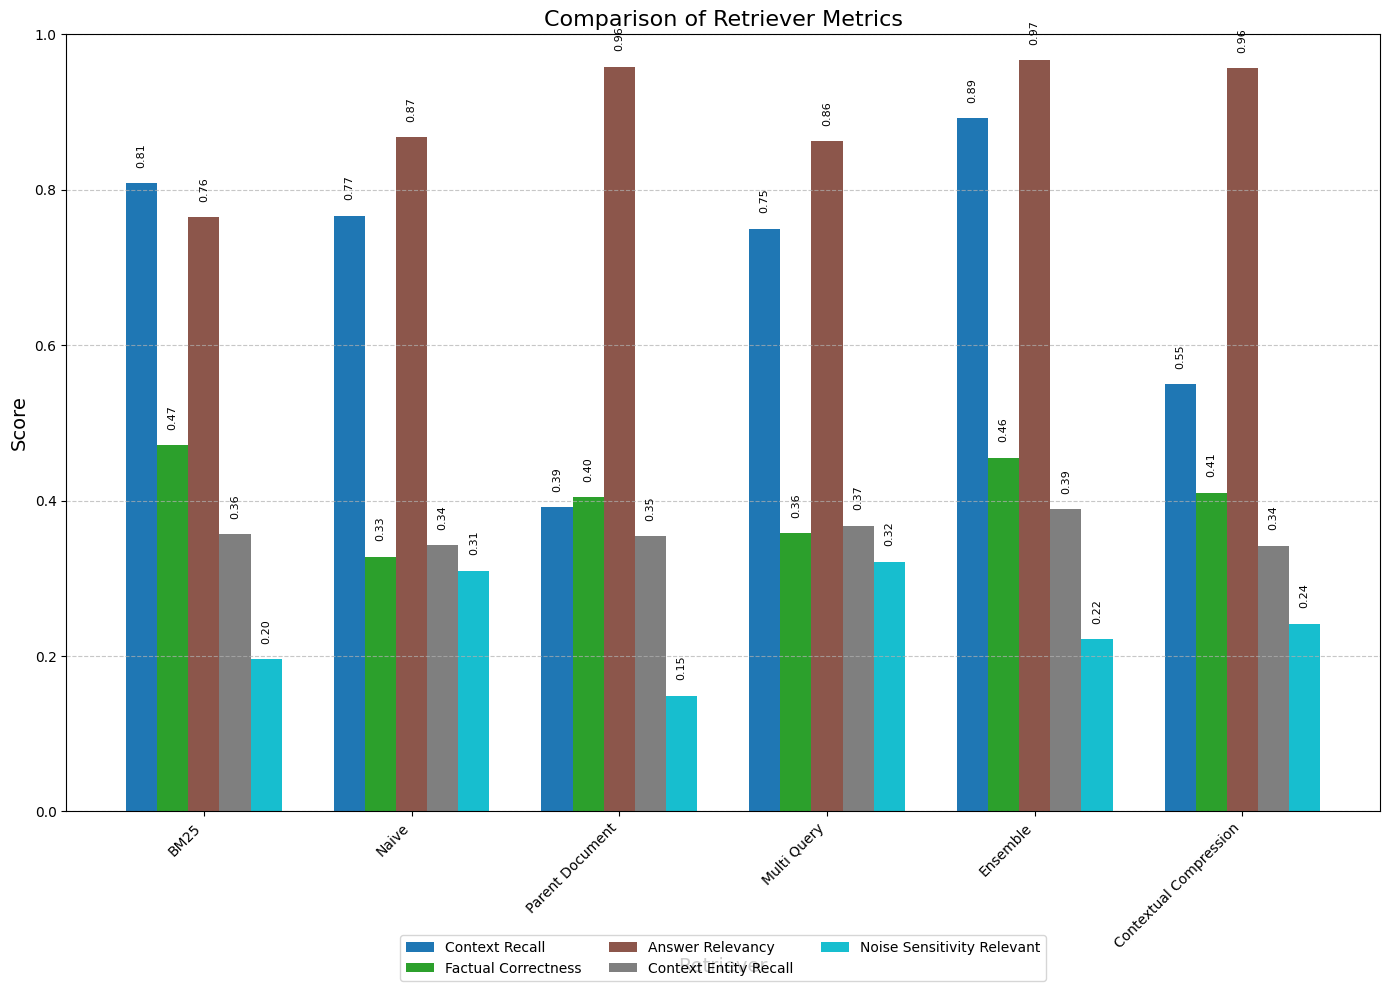

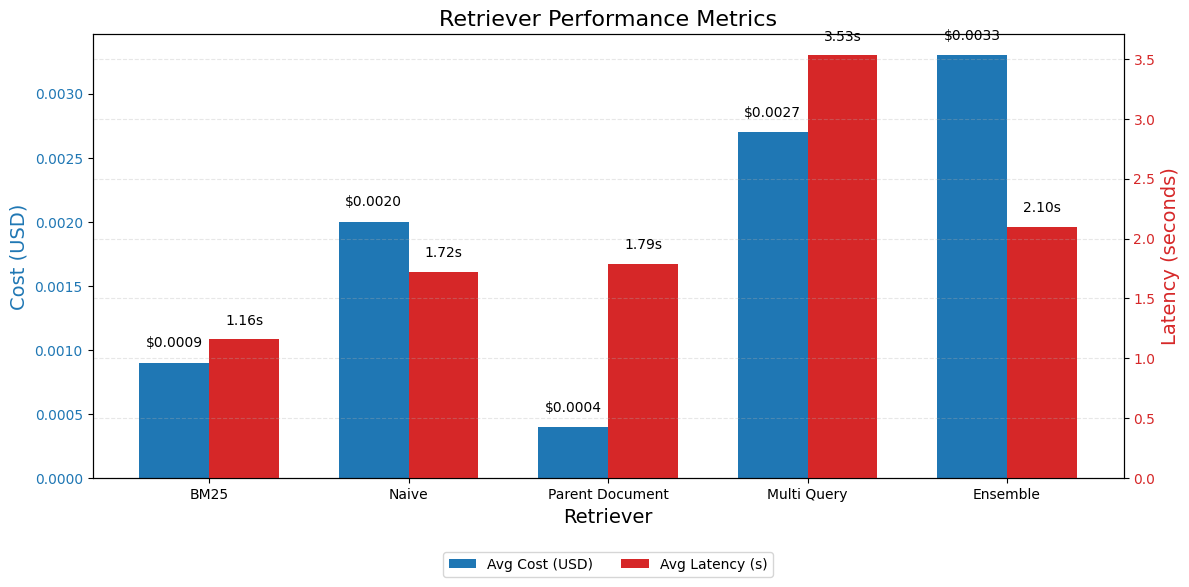

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Define the retriever names and corresponding CSV file paths
retriever_files = {
    "BM25": "bm25.csv",
    "Naive": "naive.csv",
    "Parent Document": "parent_document.csv",
    "Multi Query": "multi_query.csv",
    "Ensemble": "ensemble.csv"
}

# Define the evaluation metrics for each retriever
evaluation_metrics = {
    "BM25": {'context_recall': 0.8083, 'factual_correctness': 0.4710, 'answer_relevancy': 0.7645, 'context_entity_recall': 0.3566, 'noise_sensitivity_relevant': 0.1958},
    "Naive": {'context_recall': 0.7667, 'factual_correctness': 0.3280, 'answer_relevancy': 0.8675, 'context_entity_recall': 0.3427, 'noise_sensitivity_relevant': 0.3095},
    "Parent Document": {'context_recall': 0.3917, 'factual_correctness': 0.4040, 'answer_relevancy': 0.9584, 'context_entity_recall': 0.3540, 'noise_sensitivity_relevant': 0.1486},
    "Contextual Compression": {'context_recall': 0.5500, 'factual_correctness': 0.4100, 'answer_relevancy': 0.9565, 'context_entity_recall': 0.3421, 'noise_sensitivity_relevant': 0.2416},
    "Multi Query": {'context_recall': 0.7500, 'factual_correctness': 0.3580, 'answer_relevancy': 0.8623, 'context_entity_recall': 0.3676, 'noise_sensitivity_relevant': 0.3210},
    "Ensemble": {'context_recall': 0.8917, 'factual_correctness': 0.4550, 'answer_relevancy': 0.9663, 'context_entity_recall': 0.3888, 'noise_sensitivity_relevant': 0.2214}
}

# Collect all evaluation metrics
all_metrics_df = pd.DataFrame(evaluation_metrics).T.reset_index()
all_metrics_df = all_metrics_df.rename(columns={'index': 'retriever'})

# Function to try reading CSV files and handling missing latency/cost data
def read_csv_safely(file_path):
    try:
        df = pd.read_csv(file_path)
        has_latency = 'latency' in df.columns
        has_cost = 'total_cost' in df.columns
        
        average_latency = df['latency'].mean() if has_latency else np.nan
        total_cost = df['total_cost'].sum() if has_cost else np.nan
        average_cost = df['total_cost'].mean() if has_cost else np.nan
        
        return {
            "average_latency_seconds": round(average_latency, 2) if not np.isnan(average_latency) else np.nan,
            "total_cost_usd": round(total_cost, 4) if not np.isnan(total_cost) else np.nan,
            "average_cost_usd": round(average_cost, 4) if not np.isnan(average_cost) else np.nan
        }
    except:
        return {
            "average_latency_seconds": np.nan,
            "total_cost_usd": np.nan,
            "average_cost_usd": np.nan
        }

# Read the CSV files and calculate the average latency and cost
metrics_summaries = []
for name, file_path in retriever_files.items():
    metrics_summary = {"retriever": name}
    
    # Add CSV-based metrics if available
    csv_metrics = read_csv_safely(file_path)
    metrics_summary.update(csv_metrics)
    
    # Add evaluation metrics
    if name in evaluation_metrics:
        metrics_summary.update(evaluation_metrics[name])
    
    metrics_summaries.append(metrics_summary)

# For Contextual Compression (which doesn't have a CSV), add just the evaluation metrics
if "Contextual Compression" not in retriever_files:
    cc_metrics = {"retriever": "Contextual Compression"}
    cc_metrics.update({
        "average_latency_seconds": np.nan,
        "total_cost_usd": np.nan,
        "average_cost_usd": np.nan
    })
    if "Contextual Compression" in evaluation_metrics:
        cc_metrics.update(evaluation_metrics["Contextual Compression"])
    metrics_summaries.append(cc_metrics)

# Convert the metrics summaries to a DataFrame
metrics_df = pd.DataFrame(metrics_summaries)

# Create single unified visualization
def plot_all_metrics_in_one(metrics_df):
    # Prepare data for plotting
    # Get only the evaluation metrics (exclude retriever, latency, and cost columns)
    eval_metrics = [col for col in metrics_df.columns 
                   if col not in ['retriever', 'average_latency_seconds', 'total_cost_usd', 'average_cost_usd']]
    
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 10))
    
    # Define the colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(eval_metrics)))
    
    # Create a bar chart for each metric
    bar_width = 0.15
    x = np.arange(len(metrics_df['retriever']))
    
    for i, metric in enumerate(eval_metrics):
        offset = i * bar_width
        plt.bar(x + offset, metrics_df[metric], width=bar_width, 
                label=metric.replace('_', ' ').title(), color=colors[i])
    
    # Add labels and title
    plt.xlabel('Retriever', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Comparison of Retriever Metrics', fontsize=16)
    plt.xticks(x + bar_width * (len(eval_metrics) - 1) / 2, metrics_df['retriever'], rotation=45, ha='right')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    
    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust the layout
    plt.tight_layout()
    plt.ylim(0, 1.0)  # Since these are mostly normalized scores
    
    # Add value labels on top of each bar
    for i, metric in enumerate(eval_metrics):
        for j, value in enumerate(metrics_df[metric]):
            plt.text(j + i * bar_width, value + 0.02, f'{value:.2f}', 
                     ha='center', va='bottom', fontsize=8, rotation=90)
    
    plt.savefig('retriever_evaluation_metrics.png', bbox_inches='tight', dpi=300)
    plt.show()

# Create separate visualization for latency and cost if available
def plot_performance_metrics(metrics_df):
    # Check if we have any cost or latency data
    has_cost = not metrics_df['average_cost_usd'].isna().all()
    has_latency = not metrics_df['average_latency_seconds'].isna().all()
    
    if not has_cost and not has_latency:
        print("No cost or latency data available to plot")
        return
    
    # Filter out rows with missing data for both metrics
    metrics_to_plot = []
    if has_cost:
        metrics_to_plot.append('average_cost_usd')
    if has_latency:
        metrics_to_plot.append('average_latency_seconds')
    
    # Only keep retrievers that have at least one of the metrics
    perf_df = metrics_df.dropna(subset=metrics_to_plot, how='all')
    
    if len(perf_df) == 0:
        print("No complete data available for performance metrics")
        return
    
    # Set up the figure
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(perf_df['retriever']))
    bar_width = 0.35
    
    # Plot the cost on the first axis if available
    if has_cost:
        ax1.set_xlabel('Retriever', fontsize=14)
        ax1.set_ylabel('Cost (USD)', color='tab:blue', fontsize=14)
        bars1 = ax1.bar(x - bar_width/2, perf_df['average_cost_usd'], 
                        bar_width, label='Avg Cost (USD)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        
        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            if not np.isnan(height):
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                        f'${height:.4f}', ha='center', va='bottom', fontsize=10)
    
    # Plot the latency on the second axis if available
    if has_latency:
        if has_cost:
            ax2 = ax1.twinx()
            ax2.set_ylabel('Latency (seconds)', color='tab:red', fontsize=14)
            bars2 = ax2.bar(x + bar_width/2, perf_df['average_latency_seconds'], 
                           bar_width, label='Avg Latency (s)', color='tab:red')
            ax2.tick_params(axis='y', labelcolor='tab:red')
            
            # Add value labels
            for bar in bars2:
                height = bar.get_height()
                if not np.isnan(height):
                    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                            f'{height:.2f}s', ha='center', va='bottom', fontsize=10)
        else:
            ax1.set_xlabel('Retriever', fontsize=14)
            ax1.set_ylabel('Latency (seconds)', fontsize=14)
            bars1 = ax1.bar(x, perf_df['average_latency_seconds'], 
                           0.7, label='Avg Latency (s)', color='tab:red')
            
            # Add value labels
            for bar in bars1:
                height = bar.get_height()
                if not np.isnan(height):
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                            f'{height:.2f}s', ha='center', va='bottom', fontsize=10)
    
    # Set xticks
    plt.xticks(x, perf_df['retriever'], rotation=45, ha='right')
    
    # Add legends
    if has_cost and has_latency:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', 
                  bbox_to_anchor=(0.5, -0.15), ncol=2)
    else:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
    
    plt.title('Retriever Performance Metrics', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    plt.savefig('retriever_performance_metrics.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot all metrics as requested
plot_all_metrics_in_one(metrics_df)

# Optionally plot performance metrics (cost/latency) separately
# Uncomment the next line if you want to see cost/latency separately
plot_performance_metrics(metrics_df)

### Overall Takeaways:
- There's a trade-off between retrieval quality and computational cost across most retrievers.
- Ensemble delivers the best overall quality but at the highest cost.
- Parent Document offers the best cost-efficiency despite lower recall, with excellent answer relevancy and noise resistance.
- BM25 provides a good quality-to-cost ratio as a baseline approach.
- The best choice depends on priority: if budget is primary, Parent Document works well; if quality matters most, Ensemble is superior.
